# **Decode COVID19 with Genome Analysis**

**Problem Statement :**
You are one of the researchers responding to the White House Office of Science and Technology Policy center’s call to conduct advanced research on Covid-19. You are working with CDC,  which has led a coordinated effort to set up a machine readable dataset.

**About Dataset :**
Dataset represents the most extensive machine-readable coronavirus literature collection available for data and text mining to date, with over 29,000 articles, more than 13,000 of which have full text.

Using the **CORD-NER dataset** and Knowledge Graph, determine and map out the details of the SARS-CoV-2 genome to assist understanding of the emergence, evolution and diagnosis of this deadly virus.



In [ ]:

import gc
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:

import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import collections
import wordcloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
import spacy
import gensim.corpora as corpora
from gensim.models import LdaMulticore, CoherenceModel, Phrases, LdaModel
import time
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure,show,output_notebook
import pyLDAvis
import warnings
import pprint
import tensorflow as tf

pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')
%matplotlib inline

# 1. Importing Dataset & preprocessing

In [ ]:
#importing 10000 rows from CORD-NER-full json file
json_data = pd.read_json('/kaggle/input/jsonfull/CORD-NER-full.json',nrows=10000, lines=True)


In [ ]:
#clearing cache to avoid ran out of memory error
import gc
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
#conversion to csv
json_data.to_csv('CORD_NER-Full.csv')

In [ ]:
#importing csv data
data = pd.read_csv('/kaggle/working/CORD_NER-Full.csv')
data.head(10)

,Unnamed: 0,id,source,doi,pmcid,pubmed_id,publish_time,authors,journal,title,abstract,body,entities
0,0,0,CZI,10.1007/s00134-020-05985-9,NaN,32125455.0,2020,"Zhang, Haibo; Penninger, Josef M.; Li, Yimin; ...",Intensive Care Med,Angiotensin-converting enzyme 2 (ACE2) as a SA...,NaN,SARS-CoV-2 has been sequenced [3] . A phylogen...,"[{'text': 'Angiotensin-converting enzyme 2', '..."
1,1,1,CZI,10.1038/s41421-020-0147-1,NaN,NaN,2020,"Cao, Yanan; Li, Lin; Feng, Zhimin; Wan, Shengq...",Cell Discovery,Comparative genetic analysis of the novel coro...,NaN,Comparative genetic analysis of the novel coro...,"[{'text': 'genetic analysis', 'start': 12, 'en..."
2,2,2,CZI,10.3390/jcm9020538,NaN,NaN,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,Incubation Period and Other Epidemiological Ch...,The geographic spread of 2019 novel coronaviru...,"As of 31 January 2020, mainland China reported...","[{'text': '2019', 'start': 63, 'end': 67, 'typ..."
3,3,3,CZI,10.3390/jcm9020575,NaN,32093211.0,2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,Characteristics of and Public Health Responses...,"In December 2019, cases of unidentified pneumo...","In December 2019, a cluster of pneumonia of un...","[{'text': 'Public Health', 'start': 23, 'end':..."
4,4,4,CZI,10.1007/s00134-020-05976-w,NaN,32125453.0,2020,"Zhang, Wei",Intensive Care Med,Imaging changes in severe COVID-19 pneumonia,NaN,NaN,"[{'text': 'COVID-19', 'start': 26, 'end': 34, ..."
5,5,5,CZI,10.1016/j.idm.2020.02.001,NaN,NaN,2020,"Tang, Biao; Bragazzi, Nicola Luigi; Li, Qian; ...",Infectious Disease Modelling,An updated estimation of the risk of transmiss...,The basic reproduction number of an infectious...,Coronaviruses are a group of enveloped viruses...,"[{'text': 'coronavirus', 'start': 63, 'end': 7..."
6,6,6,CZI,10.1016/j.idm.2020.02.002,NaN,NaN,2020,"Roosa, K.; Lee, Y.; Luo, R.; Kirpich, A.; Roth...",Infectious Disease Modelling,Real-time forecasts of the 2019-nCoV epidemic ...,The initial cluster of severe pneumonia cases ...,The ongoing epidemic of the novel coronavirus ...,"[{'text': '2019-nCoV', 'start': 27, 'end': 36,..."
7,7,7,CZI,10.1016/s2214-109x(20)30065-6,NaN,32105614.0,2020,"Zeng, Yingchun; Zhen, Yan",The Lancet. Global health,RETRACTED: Chinese medical staff request inter...,NaN,NaN,"[{'text': 'Chinese', 'start': 11, 'end': 18, '..."
8,8,8,CZI,10.1093/jtm/taaa030,NaN,NaN,2020,"Rocklöv, J.; Sjödin, H.; Wilder-Smith, A.",Journal of Travel Medicine,COVID-19 outbreak on the Diamond Princess crui...,Cruise ships carry a large number of people in...,Conclusions: The cruise ship conditions clearl...,"[{'text': 'COVID-19', 'start': 0, 'end': 8, 't..."
9,9,9,CZI,10.1128/mBio.02764-19,NaN,NaN,2020,"Qing, Enya; Hantak, Michael; Perlman, Stanley;...",mBio,Distinct Roles for Sialoside and Protein Recep...,Coronaviruses (CoVs) are common human and anim...,could be attributed to S proteins. Intriguingl...,"[{'text': 'Sialoside', 'start': 19, 'end': 28,..."


In [ ]:
#clearing cache to avoid ran out of memory error
import gc
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
#creating new dataframe for required columns
df_covid = pd.DataFrame(columns=['paper_id', 'title','abstract', 'doi'])
df_covid['paper_id'] = data.id
df_covid['title'] = data.title
df_covid['abstract'] = data.abstract
df_covid['doi'] = data.doi

df_covid.head()

,paper_id,title,abstract,doi
0,2,Incubation Period and Other Epidemiological Ch...,the geographic spread of 2019 novel coronaviru...,10.3390/jcm9020538
1,3,Characteristics of and Public Health Responses...,"in december 2019, cases of unidentified pneumo...",10.3390/jcm9020575
2,5,An updated estimation of the risk of transmiss...,the basic reproduction number of an infectious...,10.1016/j.idm.2020.02.001
3,6,Real-time forecasts of the 2019-nCoV epidemic ...,the initial cluster of severe pneumonia cases ...,10.1016/j.idm.2020.02.002
4,8,COVID-19 outbreak on the Diamond Princess crui...,cruise ships carry a large number of people in...,10.1093/jtm/taaa030


# Duplicates and Null values.

We will look into the data and check if we have any null values.

In [ ]:
#dropping articles with missing abstract
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 772 entries, 0 to 771
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   paper_id  772 non-null    int64 
 1   title     772 non-null    object
 2   abstract  772 non-null    object
 3   doi       772 non-null    object
dtypes: int64(1), object(3)
memory usage: 24.2+ KB


In [ ]:
df_covid.drop_duplicates(['abstract'], inplace=True)
df_covid.dropna(inplace=True)
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 772 entries, 0 to 771
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   paper_id  772 non-null    int64 
 1   title     772 non-null    object
 2   abstract  772 non-null    object
 3   doi       772 non-null    object
dtypes: int64(1), object(3)
memory usage: 30.2+ KB


# Dropping non-English articles.

Now we dropped the null values, and removed the duplicates as well. Now we will check the number of non-english articles and see if we can drop them for the sake of simplicity.

In [ ]:

DetectorFactory.seed = 0


languages = []


for ii in tqdm(range(0,len(df_covid))):

    text = df_covid.iloc[ii]['abstract'].split(" ")

    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))

    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))

        except Exception as e:
            lang = "unknown"
            pass


    languages.append(lang)

100%|██████████| 772/772 [00:06<00:00, 113.43it/s]


**Let's look at the numbers of articles for each language.**

In [ ]:

import gc
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)

print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 772

{'ca': 1, 'de': 2, 'en': 749, 'es': 11, 'ja': 1, 'pt': 4, 'zh-cn': 4}


**Since most of the articles are in English, we can safely drop non-English articles.**

In [ ]:
df_covid['language'] = languages
df_covid = df_covid[df_covid['language'] == 'en']
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 749 entries, 0 to 771
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   paper_id  749 non-null    int64 
 1   title     749 non-null    object
 2   abstract  749 non-null    object
 3   doi       749 non-null    object
 4   language  749 non-null    object
dtypes: int64(1), object(4)
memory usage: 35.1+ KB


In [ ]:
df_covid = df_covid.drop(['language'], axis = 1)
df_covid.head()

,paper_id,title,abstract,doi
0,2,Incubation Period and Other Epidemiological Ch...,the geographic spread of 2019 novel coronaviru...,10.3390/jcm9020538
1,3,Characteristics of and Public Health Responses...,"in december 2019, cases of unidentified pneumo...",10.3390/jcm9020575
2,5,An updated estimation of the risk of transmiss...,the basic reproduction number of an infectious...,10.1016/j.idm.2020.02.001
3,6,Real-time forecasts of the 2019-nCoV epidemic ...,the initial cluster of severe pneumonia cases ...,10.1016/j.idm.2020.02.002
4,8,COVID-19 outbreak on the Diamond Princess crui...,cruise ships carry a large number of people in...,10.1093/jtm/taaa030


In [ ]:
from pyLDAvis import gensim

In [ ]:

%%time
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus_cov_article, id2token_cov_article)

/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


CPU times: user 588 ms, sys: 371 ms, total: 959 ms
Wall time: 2.46 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.011997 -0.010009       1        1  25.919369
5     -0.042126 -0.005786       2        1  16.098194
6      0.154280  0.020210       3        1  14.852741
4      0.094154 -0.143981       4        1  13.655068
1     -0.124302 -0.020995       5        1   8.510871
3      0.075793  0.086981       6        1   8.147709
7     -0.117039 -0.033860       7        1   7.763904
2     -0.028765  0.107440       8        1   5.052144, topic_info=              Term        Freq       Total Category  logprob  loglift
239        patient  867.000000  867.000000  Default  30.0000  30.0000
61            case  631.000000  631.000000  Default  29.0000  29.0000
56           virus  375.000000  375.000000  Default  28.0000  28.0000
3687           say   75.000000   75.000000  Default  27.0000  27.0000
597         lesion   67.000000   67.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
88        identify    7.241000  110.220454   Topic8  -5.8233   0.2626
9     distribution    6.427018   40.038723   Topic8  -5.9425   1.1560
247         reduce    6.227309   50.937171   Topic8  -5.9741   0.8837
514          group    6.372201  111.386918   Topic8  -5.9511   0.1243
121   transmission    6.151585  160.338375   Topic8  -5.9863  -0.2752

[633 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
2333      3  0.856271     abnormal
2333      5  0.095141     abnormal
2333      8  0.047571     abnormal
1885      1  0.125546  abnormality
1885      6  0.753276  abnormality
...     ...       ...          ...
1826      3  0.028027    worldwide
1826      5  0.028027    worldwide
1826      6  0.028027    worldwide
1826      7  0.112108    worldwide
1826      8  0.056054    worldwide

[1481 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 7, 5, 2, 4, 8, 3])

As we can see from the interactive figure above, topic 1 and 2  are very close as well as 7 and 8 (5 is also similar to 7). The other topics are separated appropriately.


# Topic per document

In [ ]:
document_topic_distribution = []
num_topic_document = []
topic_frequency = {}
for i in range(len(corpus_cov_article)):
    document_topic = lda_model.get_document_topics(corpus_cov_article[i])
    document_topic_distribution.append(document_topic)
    num_topic_document.append(len(document_topic))
    for topic_idx,prob in document_topic:
        if topic_idx not in topic_frequency:
            topic_frequency[topic_idx] = 1
        else:
            topic_frequency[topic_idx] += 1

topic_frequency = dict(sorted(topic_frequency.items()))

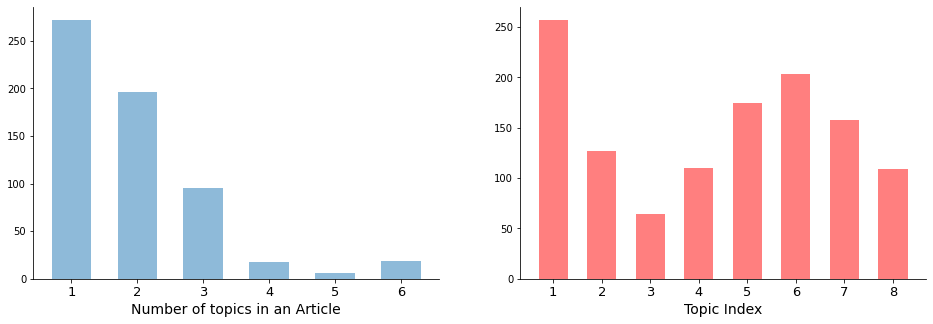

In [ ]:

num_topic_document_counter = (pd.DataFrame(num_topic_document)).value_counts(sort=False)
counter_idx = [str(idx[0]) for idx in num_topic_document_counter.index]
counter_values = num_topic_document_counter.values
fig,axes = plt.subplots(figsize=(16,5),nrows=1,ncols=2)
axes[0].bar(counter_idx, counter_values,width=0.6,alpha=0.5)
axes[0].set_xlabel('Number of topics in an Article',fontsize=14)

df_topic_frequency = pd.DataFrame.from_dict(topic_frequency,orient='index')
topic_idxs = [str(idx+1) for idx in df_topic_frequency.index]
axes[1].bar(topic_idxs, df_topic_frequency.iloc[:,0], width=0.6,color='red',alpha=0.5)
axes[1].set_xlabel('Topic Index',fontsize=14)

for ax in axes:
    for pos in ['top','right']:
        ax.spines[pos].set_color(None)
    ax.set_xticklabels(['1','2','3','4','5','6','7','8'],fontsize=13)

1.The left figure shows that there are very few articles who covered all the topics. 3rd and 4th topic are mostly present in many articles..

2.The right figure shows that occurence frequencies of topics are not very close as we can see many articles covered 1st and 6th topic.


In [ ]:

document_topic_matrix = np.zeros((len(corpus_cov_article),8))
for idx,document_topic in enumerate(document_topic_distribution):
    for topic_idx,prob in document_topic:
        document_topic_matrix[idx][topic_idx] = prob
pd.DataFrame(document_topic_matrix).head()

,0,1,2,3,4,5,6,7
0,0.253347,0.000000,0.000000,0.344171,0.393902,0.000000,0.0,0.00000
1,0.000000,0.000000,0.989183,0.000000,0.000000,0.000000,0.0,0.00000
2,0.576381,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.41725
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.993959,0.0,0.00000
4,0.000000,0.994201,0.000000,0.000000,0.000000,0.000000,0.0,0.00000


In [ ]:

tSNE = TSNE(n_components=2,init='pca',random_state=98)
embedding_matrix = tSNE.fit_transform(document_topic_matrix)
df_embedding = pd.DataFrame(embedding_matrix, columns=['X_TSNE','Y_TSNE'])
cluster_colors = {0: 'blue', 1: 'green', 2: 'yellow',
                  3: 'red', 4: 'skyblue', 5:'salmon',
                  6: 'purple', 7:'darkred'}
df_embedding['dominant_topic_idx'] = np.argmax(document_topic_matrix,axis=1)
df_embedding['color'] = df_embedding['dominant_topic_idx'].map(cluster_colors)
cluster_labels = {0: 'Infection prevention measures by hospital', 1: 'Evolution of virus',
                  2: 'Drugs for atypical pneumonia and myocardial',
                  3: 'lesions in lungs', 4: 'Observation on COVID19 patient', 5:'Rise of COVID19 in the Country',
                  6: 'Symptoms of COVID19', 7: 'Research on vaccine'}
df_embedding['label'] = df_embedding['dominant_topic_idx'].map(cluster_labels)
df_embedding['article_title'] = list(cov_article['title'])

output_notebook()

source = ColumnDataSource(
    dict(x = df_embedding['X_TSNE'],
         y = df_embedding['Y_TSNE'],
         color=df_embedding['color'],
         label=df_embedding['label'],
         topic_key= df_embedding['dominant_topic_idx'],
         title= df_embedding['article_title'],
         #content =
        ))

lda_plot = figure(title='T-SNE Clustering of LDA Topics',
              plot_width=800, plot_height=600,
              tools='pan,wheel_zoom,box_zoom,reset,hover',
              x_axis_type=None, y_axis_type=None)
lda_plot.scatter(x='x', y='y', source=source,
                 legend='label', color='color',alpha=0.7, size=10)
hover = lda_plot.select(dict(type=HoverTool))
hover.tooltips = {'content':'Title: @title'}
lda_plot.legend.location = 'bottom_right'
show(lda_plot)

Loading BokehJS ...

# **Semantic-Based Search**

**Why Choose T-SNE?**

T-SNE gives the impression that it has classified the data by bringing it to two-dimensions but in reality, it doesn’t reduce the dimensions. It is a visualizer, which tells how each class is distributed and is there any overlap between them'. An intuition of T-SNE from the article on Medium: PCA vs LDA vs T-SNE — Let’s Understand the difference between them.



In [ ]:

!pip install langdetect


import string
import warnings

from pprint import pprint
from IPython.utils import io
from gensim.models import Word2Vec
from langdetect import DetectorFactory, detect
from spacy.lang.en.stop_words import STOP_WORDS

warnings.filterwarnings('ignore')

# Spacy Parser and Tokenizer

In [ ]:
punctuations = string.punctuation

stopwords = list(STOP_WORDS)
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure',
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.',
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

In [ ]:
# Parser
parser = spacy.load('en_core_web_lg',disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens


tqdm.pandas()
df_covid["processed_abstract"] = df_covid["abstract"].progress_apply(spacy_tokenizer)
df_covid.head()

100%|██████████| 749/749 [00:17<00:00, 41.81it/s]


,paper_id,title,abstract,doi,processed_abstract
0,2,Incubation Period and Other Epidemiological Ch...,the geographic spread of 2019 novel coronaviru...,10.3390/jcm9020538,geographic spread 2019 novel coronavirus covid...
1,3,Characteristics of and Public Health Responses...,"in december 2019, cases of unidentified pneumo...",10.3390/jcm9020575,december 2019 cases unidentified pneumonia his...
2,5,An updated estimation of the risk of transmiss...,the basic reproduction number of an infectious...,10.1016/j.idm.2020.02.001,basic reproduction number infectious agent ave...
3,6,Real-time forecasts of the 2019-nCoV epidemic ...,the initial cluster of severe pneumonia cases ...,10.1016/j.idm.2020.02.002,initial cluster severe pneumonia cases trigger...
4,8,COVID-19 outbreak on the Diamond Princess crui...,cruise ships carry a large number of people in...,10.1093/jtm/taaa030,cruise ships carry large number people confine...


# Sentence Tokenization
gensim's word2vec corpus should be in the form of separate sentences, therefore we will use spacy's tokenizer in order to split the corpus (all the abstracts) into sentences.

In [ ]:

abstracts = df_covid['abstract'].values

nlp = spacy.load('en_core_web_lg',disable = ['ner', 'tagger'])
nlp.add_pipe('sentencizer', before="parser")
word2vec_corpus = []

for i in tqdm(range(0, len(abstracts))):
    raw_text = abstracts[i]
    doc = nlp(raw_text)
    sentences = [sent.text.strip() for sent in doc.sents]

    for sent in sentences:
        processed_sent = spacy_tokenizer(sent)
        processed_sent_list = processed_sent.split(" ")
        word2vec_corpus.append(processed_sent_list)

100%|██████████| 749/749 [00:49<00:00, 15.25it/s]


In [ ]:
word2vec_corpus[:10]

[['geographic',
  'spread',
  '2019',
  'novel',
  'coronavirus',
  'covid-19',
  'infections',
  'epicenter',
  'wuhan',
  'china',
  'provided',
  'opportunity',
  'study',
  'natural',
  'history',
  'recently',
  'emerged',
  'virus'],
 ['publicly',
  'available',
  'event',
  'date',
  'data',
  'ongoing',
  'epidemic',
  'present',
  'study',
  'investigated',
  'incubation',
  'period',
  'time',
  'intervals',
  'govern',
  'epidemiological',
  'dynamics',
  'covid-19',
  'infections'],
 ['results',
  'incubation',
  'period',
  'falls',
  'range',
  '2&ndash;14',
  'days',
  '95',
  'confidence',
  'mean',
  '5',
  'days',
  'approximated',
  'best',
  'fit',
  'lognormal',
  'distribution'],
 ['mean',
  'time',
  'illness',
  'onset',
  'hospital',
  'admission',
  'treatment',
  'and/or',
  'isolation',
  'estimated',
  '3&ndash;4',
  'days',
  'truncation',
  '5&ndash;9',
  'days',
  'right',
  'truncated'],
 ['based',
  '95th',
  'percentile',
  'estimate',
  'incubation',

# Word2vec Training
We will use gensim's word2vec and train it on the corpus we prepared. min_count is the minimum count for a word to occur in the corpus in order to be mapped to a vector. size is the size of the vectors produced. workers is the number of cores. window is the context size to consider. sg is skipgram model. The min_count, size and window were calculated empirically.

In [ ]:
# Train the genisim word2vec model with our own custom corpus
model = Word2Vec(word2vec_corpus, min_count=3,vector_size= 50,workers=4, window =5, sg = 1)

In [ ]:


a = [0.0]*50
df_covid["centroid"] = [a]*df_covid.shape[0]

for index, row in df_covid.iterrows():
    abstract = row['processed_abstract']
    total_sim = 0
    words = abstract.split(" ")
    centroid = np.array([0.0]*50)
    for word in words:
        try:
            b = model.wv[word]
        except:
            continue
        centroid = np.add(centroid, b)

    df_covid.at[index,'centroid'] = centroid.tolist()

df_covid.head(20)

,paper_id,title,abstract,doi,processed_abstract,centroid
0,2,Incubation Period and Other Epidemiological Ch...,the geographic spread of 2019 novel coronaviru...,10.3390/jcm9020538,geographic spread 2019 novel coronavirus covid...,"[26.717240484431386, -7.6421342614339665, -16...."
1,3,Characteristics of and Public Health Responses...,"in december 2019, cases of unidentified pneumo...",10.3390/jcm9020575,december 2019 cases unidentified pneumonia his...,"[35.8029131796211, -11.433286741143093, -10.58..."
2,5,An updated estimation of the risk of transmiss...,the basic reproduction number of an infectious...,10.1016/j.idm.2020.02.001,basic reproduction number infectious agent ave...,"[28.99859413743252, 1.6823107888922095, -10.92..."
3,6,Real-time forecasts of the 2019-nCoV epidemic ...,the initial cluster of severe pneumonia cases ...,10.1016/j.idm.2020.02.002,initial cluster severe pneumonia cases trigger...,"[63.28405757341534, -5.927030952065252, -41.82..."
4,8,COVID-19 outbreak on the Diamond Princess crui...,cruise ships carry a large number of people in...,10.1093/jtm/taaa030,cruise ships carry large number people confine...,"[45.29122933000326, -11.80206878343597, -22.90..."
5,9,Distinct Roles for Sialoside and Protein Recep...,coronaviruses (covs) are common human and anim...,10.1128/mBio.02764-19,coronaviruses covs common human animal pathoge...,"[51.69257419556379, 18.718293792568147, 36.268..."
6,10,First two months of the 2019 Coronavirus Disea...,similar to outbreaks of many other infectious ...,10.1186/s41256-020-00137-4,similar outbreaks infectious diseases success ...,"[3.0292712599039078, 2.624109884724021, -1.019..."
7,11,Effectiveness of airport screening at detectin...,we simulated 100 2019-ncov infected travellers...,10.2807/1560-7917.ES.2020.25.5.2000080,simulated 100 2019 ncov infected travellers pl...,"[25.890380350872874, -6.816300565842539, -12.4..."
8,12,Genome Detective Coronavirus Typing Tool for r...,"summary: genome detective is a web-based, user...",10.1093/bioinformatics/btaa145,summary genome detective web based user friend...,"[25.82366358023137, 4.394622181833256, 3.22269..."
9,13,Case of the Index Patient Who Caused Tertiary ...,"since mid-december of 2019, coronavirus diseas...",10.3346/jkms.2020.35.e79,mid december 2019 coronavirus disease 2019 cov...,"[21.898087350651622, -8.062655892921612, -12.3..."


In [ ]:
model = Word2Vec(word2vec_corpus, min_count=3,vector_size= 50,workers=4, window =5, sg = 1)
model.wv['word']

array([ 0.14335708,  0.06947225, -0.01952   ,  0.03257594, -0.11595847,
       -0.253102  ,  0.24411911,  0.14827888, -0.25560018, -0.02211461,
       -0.13986109, -0.24973254, -0.03102888,  0.12887412, -0.05612806,
        0.13125044,  0.1543322 , -0.057005  , -0.1696314 , -0.05040606,
       -0.03927866,  0.10145514,  0.22033203, -0.09573624,  0.11516662,
        0.08696358, -0.09503484,  0.04836602, -0.13419561,  0.12379242,
        0.04441796, -0.08787449,  0.00929561,  0.11486302, -0.13229504,
        0.1350935 , -0.06793314,  0.05350947,  0.0257303 , -0.09546565,
        0.08466023, -0.00971301,  0.02459955,  0.10806477,  0.32869476,
       -0.0147201 , -0.12734455, -0.14889918,  0.11797328,  0.08497495],
      dtype=float32)

# Ranking documents
Now we will create a function that given a query, would rank the documents from most similar to least similar.

In [ ]:
def rank_docs(model, query, df_covid, num) :
    #[(paper_id, processed_abstract, url, cosine_sim)]
    cosine_list = []

    a = []
    query = query.split(" ")
    for q in query:
        try:
            a.append(model[q])
        except:
            continue

    for index, row in df_covid.iterrows():
        centroid = row['centroid']
        total_sim = 0
        for a_i in a:
            cos_sim = np.dot(a_i, centroid)/(np.linalg.norm(a_i)*np.linalg.norm(centroid))
            total_sim += cos_sim
        cosine_list.append((row['title'], row['doi'], total_sim))


    cosine_list.sort(key=lambda x:x[2], reverse=True) ## in Descedning order

    papers_list = []
    for item in cosine_list[:num]:
        papers_list.append((item[0], item[1], item[2]))
    return papers_list

# Saving the model and the dataframe

In [ ]:
model.save("./model.model")
df_covid.to_pickle("./df_covid.pkl")

**Loading the model and the data**

The save/load steps are done in order to avoid re-training the model each time.

In [ ]:
saved_model = Word2Vec.load("./model.model")
saved_df_covid = pd.read_pickle("./df_covid.pkl")

# Results
Now let's see some results using our model. query() function takes the query string as an input, together with a number representing the top matches you want, and print the titles of the top matches most relevant articles retrieved for each query, clicking the title a new tab will open with the paper.

In [ ]:
def query(the_query, top_matches=10):
    q = spacy_tokenizer(the_query)
    try:
        model_to_use = model
    except:
        model_to_use = saved_model
    try:
        df_covid_to_use = df_covid
    except:
        df_covid_to_use = saved_df_covid
    results = rank_docs(model_to_use, q, df_covid_to_use, top_matches)

    for i in range(len(results)):
        paper_name = results[i][0]
        paper_doi = results[i][1]
        paper_link = "https://doi.org/" + str(paper_doi)
    display(paper_name)
    display(paper_link)

# **What do we know about virus origin, genetics and evolution?**

In [ ]:
query('origin of coronavirus')

'Case of the Index Patient Who Caused Tertiary Transmission of Coronavirus Disease 2019 in Korea: the Application of Lopinavir/Ritonavir for the Treatment of COVID-19 Pneumonia Monitored by Quantitative RT-PCR'

'https://doi.org/10.3346/jkms.2020.35.e79'

In [ ]:
query('covid19 genetics', top_matches =9)

'Genome Detective Coronavirus Typing Tool for rapid identification and characterization of novel coronavirus genomes'

'https://doi.org/10.1093/bioinformatics/btaa145'

In [ ]:
query(' coronavirus')

'Case of the Index Patient Who Caused Tertiary Transmission of Coronavirus Disease 2019 in Korea: the Application of Lopinavir/Ritonavir for the Treatment of COVID-19 Pneumonia Monitored by Quantitative RT-PCR'

'https://doi.org/10.3346/jkms.2020.35.e79'